# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [1]:
#импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch import FloatTensor
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.model_selection import GroupShuffleSplit
from tqdm.notebook import trange

from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
import torch.optim as optim

from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import notebook

RAND = 42
PATH = './to_upload'

[nltk_data] Downloading package stopwords to /Users/bunny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [2]:
#загрузим данные
train_dataset = pd.read_csv(PATH + '/train_dataset.csv')
crowd_annotations = pd.read_csv(PATH + '/CrowdAnnotations.tsv', sep='\t', header=None)
expert_annotations = pd.read_csv(PATH + '/ExpertAnnotations.tsv', sep='\t', header=None)
test_queries = pd.read_csv(PATH + '/test_queries.csv', sep='|', index_col=0)
test_images = pd.read_csv(PATH + '/test_images.csv', sep='|')

In [720]:
#создадим единую функцию для вывода информации о данных
pd.options.display.max_columns = None
def general_function (df):

    display(df.head())

    display(df.info())

    print('Дубликаты')
    display(df.duplicated().sum())
    print('Пропуски')
    display(df.isna().sum())

In [721]:
general_function(train_dataset)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

Дубликаты


0

Пропуски


image         0
query_id      0
query_text    0
dtype: int64

In [722]:
general_function(crowd_annotations)

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

Дубликаты


0

Пропуски


0    0
1    0
2    0
3    0
4    0
dtype: int64

In [723]:
general_function(expert_annotations)

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

Дубликаты


0

Пропуски


0    0
1    0
2    0
3    0
4    0
dtype: int64

In [724]:
general_function(test_queries)

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

Дубликаты


0

Пропуски


query_id      0
query_text    0
image         0
dtype: int64

In [725]:
general_function(test_images)

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


None

Дубликаты


0

Пропуски


image    0
dtype: int64

1. Все датасеты соответствуют заявленному описанию.
2. Полные дубликаты отсутствуют.
3. Пропуски отсутствуют.

In [726]:
#добавим отсутствующие наименования столбцов в соответствии с описанием

expert_annotations.columns = ['image', 'query_id', 'exp_1', 'exp_2', 'exp_3']
crowd_annotations.columns = ['image', 'query_id', 'conf_rate', 'confirm', 'not_confirm']

Возмем медианную оценку всех экспертов для расчета агрегированной оценки экспертов. Приведем целевую переменную - оценки, в диапазон [0,1], используя масштабирование min-max

In [727]:
expert_annotations['all_expert'] = (expert_annotations[['exp_1', 'exp_2', 'exp_3']]).median(axis=1) 

In [728]:
expert_annotations['all_expert'] = (expert_annotations['all_expert'] - expert_annotations['all_expert'].min())  / \
(expert_annotations['all_expert'].max() - expert_annotations['all_expert'].min())

In [729]:
# объединим датасеты

train_df = train_dataset\
.merge(expert_annotations[['image', 'query_id', 'all_expert']], how='left', on=['image', 'query_id'])\
.merge(crowd_annotations[['image', 'query_id', 'conf_rate']], how='outer', on=['image', 'query_id'])

In [730]:
query_drop = train_dataset[['query_text', 'query_id']].drop_duplicates()

In [731]:
train_df = train_df.drop(columns=['query_text']).merge(query_drop, how="left", on=['query_id'])

In [732]:
train_df['target'] = train_df[['conf_rate', 'all_expert']].mean(axis=1)
train_df = train_df.drop(columns=['conf_rate', 'all_expert'])

In [733]:
general_function(train_df)

,image,query_id,query_text,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.166667
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   target      51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


None

Дубликаты


0

Пропуски


image            0
query_id         0
query_text    1109
target           0
dtype: int64

In [734]:
#удалим пропуски
train_df.dropna(axis = 'index', inplace = True)

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [735]:
#соберем список слов, которыми могут описываться несовершеннолетние

no_words = ['child', 
             'children',
             'baby', 
             'babies',
             'boy',
             'boys',
             'junior',
             'girl',
             'girls',
             'kid',
             'kids',
             'infant',
             'infants',
             'newborn',
             'teenager',
             'toddler',
             'toddlers']

In [736]:
#удалим строки, в которых упоминаются слова из списка
clean_df = train_df.drop( train_df[ train_df['query_text'].str.lower().str.contains('|'.join(no_words)) ].index )

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [737]:
#переведем фотографии в векторы с помощью сверточной сети ResNet-18

resnet = models.resnet18(pretrained=True);

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [738]:
for param in resnet.parameters():
    param.requires_grad_(False)

In [739]:
#возьмём все слои, кроме последнего
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [740]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

In [741]:
def image_vect(name, path, image_vectors):
    image = Image.open(path+name).convert('RGB')
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten()

    image_vectors.append(output_tensor)

In [742]:
image_train_vectors = []

clean_df['image'].apply(lambda x: image_vect(x, PATH + '/train_images/', image_train_vectors))
images_train_vect = torch.stack(image_train_vectors)

In [743]:
images_train_vect.shape

torch.Size([35822, 512])

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [744]:
train_corpus = clean_df['query_text'].values

In [745]:
nltk.download('stopwords')
count_tf_idf = TfidfVectorizer(stop_words=stopwords.words('english'))
text_train_vect = count_tf_idf.fit_transform(train_corpus)

[nltk_data] Downloading package stopwords to /Users/bunny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [746]:
text_train_vect.shape

(35822, 1124)

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [747]:
images_train_vect = images_train_vect.numpy()
text_train_vect = text_train_vect.toarray()

In [748]:
features = np.concatenate((images_train_vect, text_train_vect), axis=1)
target = clean_df.target.values

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```python
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]
```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [749]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=RAND)

train_indices, valid_indices = next(gss.split(features, target, groups=clean_df["image"].values))

X_train = features[train_indices]
y_train = target[train_indices]
X_valid = features[valid_indices]
y_valid = target[valid_indices]

### Модель линейной регрессии

In [750]:
lr_elastic = ElasticNet(alpha=0.001, random_state=RAND)
lr_elastic.fit(X_train,y_train)
y_pred_elastic = lr_elastic.predict(X_valid)

mae_elastic = mean_absolute_error(y_valid, y_pred_elastic) 
mae_elastic

0.1312610677003089

Линейная регрессия с регуляризацией ElasticNet дает MAE = 0.131

### Модель нейронной сети

In [751]:
#приведем данные к тензорам

X_train_net = torch.FloatTensor(np.array(X_train))
y_train_net = torch.FloatTensor(np.array(y_train))
X_valid_net = torch.FloatTensor(np.array(X_valid))
y_valid_net = torch.FloatTensor(np.array(y_valid))

In [752]:
X_train_net.shape

torch.Size([24915, 1636])

In [753]:
y_train_net.shape

torch.Size([24915])

In [754]:
X_valid_net.shape

torch.Size([10907, 1636])

In [755]:
y_valid_net.shape

torch.Size([10907])

In [756]:
#создадим архитектуру сети

class Net(nn.Module):
    def __init__(
        self, n_in_neurons: int, n_hidden_neurons_1: int, n_hidden_neurons_2: int, n_out_neurons: int
    ):
        super(Net, self).__init__()

        self.module = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.Tanh(),

            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ReLU(),

            nn.Linear(n_hidden_neurons_2, n_out_neurons)
        )

    def forward(self, x: FloatTensor):
        x = self.module(x)
        return x

In [757]:
# создадим функцию для обучения сети

def train_model(model, loss, optimizer, num_epochs):
    volume = []
    
    for epoch in trange(num_epochs):
        
        preds = model(X_train_net).flatten()
        loss_value = loss(preds, y_train_net)
                
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        with torch.inference_mode():
            predictions = model(X_valid_net)
            accurancy = mean_absolute_error(predictions, y_valid_net)
            volume.append([epoch, loss_value, accurancy])
            
            
            if epoch % (num_epochs // 10) == 0:
                print('Epoch {:}'.format(epoch+1))
                print('train loss: {}'.format(loss_value))
                print('accurancy {:}'.format(accurancy), '\n', '-'*50)
                

In [758]:
#определим количество слоев и нейронов для модели
n_in_neurons = X_train_net.shape[1]
n_hidden_neurons_1 = 200
n_hidden_neurons_2 = 130
n_out_neurons = 1

model = Net(n_in_neurons, 
            n_hidden_neurons_1, 
            n_hidden_neurons_2,
            n_out_neurons)

num_epochs = 2000
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.MSELoss()

train_model(model, loss, optimizer, num_epochs)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1
train loss: 0.07093708962202072
accurancy 1.0909364223480225 
 --------------------------------------------------
Epoch 201
train loss: 0.04578757286071777
accurancy 0.1552833914756775 
 --------------------------------------------------
Epoch 401
train loss: 0.03987683355808258
accurancy 0.12224928289651871 
 --------------------------------------------------
Epoch 601
train loss: 0.0381016805768013
accurancy 0.1178482249379158 
 --------------------------------------------------
Epoch 801
train loss: 0.03738725185394287
accurancy 0.11964671313762665 
 --------------------------------------------------
Epoch 1001
train loss: 0.03627727925777435
accurancy 0.1204843521118164 
 --------------------------------------------------
Epoch 1201
train loss: 0.042050838470458984
accurancy 0.11452557146549225 
 --------------------------------------------------
Epoch 1401
train loss: 0.03543530032038689
accurancy 0.1419600248336792 
 --------------------------------------------------
Epoc

Лучшее значение метрики составляет 0.114

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [759]:
#переведем изображения в векторы
image_test_vectors = []

test_df = test_queries.copy()
test_df['image'].apply(lambda x: image_vect(x, PATH + '/test_images/', image_test_vectors))
images_test_vect = torch.stack(image_test_vectors)

In [760]:
images_test_vect.shape

torch.Size([500, 512])

In [777]:
#напишем функцию для вывода изображений по запросам с помощью модели нейронной сети

def testing(text, tensors):
    print(f'Запрос: {text}')

    for word in text.split():
        if word.lower() in no_words:
            return print('DISCLAIMER: This image is unavailable in your country in compliance with local laws.')

    Xids_test = count_tf_idf.transform([text]).toarray()
    best = 0
    best_index = 0
    pred_list = []

    for i in range(len(tensors)):
        features_test = pd.DataFrame(tensors[i]).T.merge(pd.DataFrame(Xids_test), left_index=True, \
                                                      right_index=True, suffixes=(None, '_t'))
        features_test.columns = features_test.columns.astype(str)

        model.eval()

        test_tensor = torch.FloatTensor(features_test.to_numpy())
        
        target_pred_test = model(test_tensor)
        pred_list.append(target_pred_test[0])

        if target_pred_test > best:
            best = target_pred_test
            best_index = i

    print(f'Лучшая вероятность: {best}')
    print(f'Лучший индекс: {best_index}')
    print(f'Лучшее изображение:')
    img = mpimg.imread(PATH + '/test_images/' + test_queries.image[best_index])
    imgplot = plt.imshow(img)
    plt.show()

In [778]:
queries_for_test = test_df['query_text'].sample(10, random_state=RAND)
queries_for_test

361    A group of girls who are gothically dressed st...
73     A woman and girl riding downhill on a sled wit...
374                                 The dog is running .
155    A group of people are ice skating in a big city .
104    Little kid in blue coat and hat riding a tricy...
394         Two black dogs fighting over an orange toy .
377        A dog jumping for a tennis ball near an ocean
124                          Boy flying a distant kite .
68                          kids play ultimate Frisbee .
450               A girl in a purple shirt feeding ducks
Name: query_text, dtype: object

Запрос: A group of girls who are gothically dressed standing together
DISCLAIMER: This image is unavailable in your country in compliance with local laws.
Запрос: A woman and girl riding downhill on a sled with a dog running alongside them
DISCLAIMER: This image is unavailable in your country in compliance with local laws.
Запрос: The dog is running .
Лучшая вероятность: tensor([[0.2330]], grad_fn=<AddmmBackward0>)
Лучший индекс: 190
Лучшее изображение:


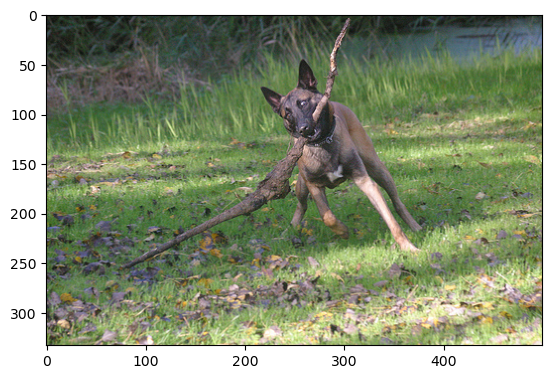

Запрос: A group of people are ice skating in a big city .
Лучшая вероятность: tensor([[0.1990]], grad_fn=<AddmmBackward0>)
Лучший индекс: 135
Лучшее изображение:


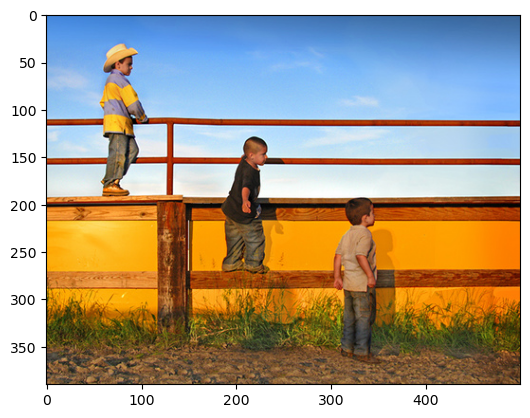

Запрос: Little kid in blue coat and hat riding a tricycle .
DISCLAIMER: This image is unavailable in your country in compliance with local laws.
Запрос: Two black dogs fighting over an orange toy .
Лучшая вероятность: tensor([[0.1982]], grad_fn=<AddmmBackward0>)
Лучший индекс: 160
Лучшее изображение:


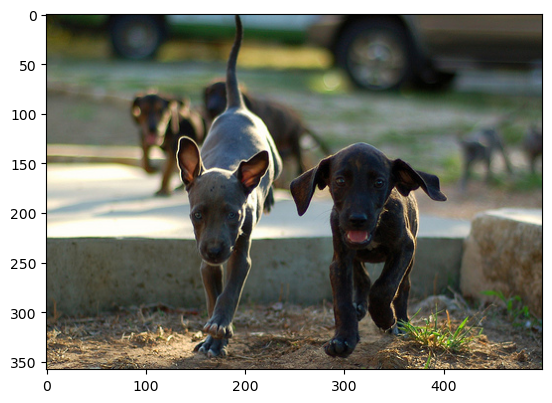

Запрос: A dog jumping for a tennis ball near an ocean
Лучшая вероятность: tensor([[0.1814]], grad_fn=<AddmmBackward0>)
Лучший индекс: 205
Лучшее изображение:


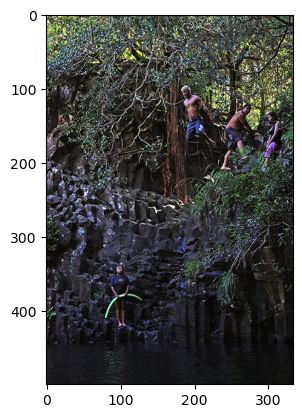

Запрос: Boy flying a distant kite .
DISCLAIMER: This image is unavailable in your country in compliance with local laws.
Запрос: kids play ultimate Frisbee .
DISCLAIMER: This image is unavailable in your country in compliance with local laws.
Запрос: A girl in a purple shirt feeding ducks
DISCLAIMER: This image is unavailable in your country in compliance with local laws.


In [779]:
for query in queries_for_test:
    testing(query, images_test_vect)

## 8. Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска

Качество работы модели не очень высокое. Скорее всего это связано с низким качеством разметки изображений. Можно попробовать альтернативный вариант - использовать только оценки экспертов, а также доработать модель неронной сети (например, добавить разные варианты размеров батчей и/или дропаутов.